In [422]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.integrate import odeint
from scipy.optimize import curve_fit
import gillespie as gp
import statistics as st
import seaborn as sns
import networkx as nx
import pandas as pd

import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc

from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.bokeh.DiffusionPrevalence import DiffusionPrevalence
from ndlib.viz.bokeh.MultiPlot import MultiPlot

from bokeh.io import output_notebook, show
from bokeh.plotting import figure, show
from bokeh.layouts import gridplot, column

from mpl_toolkits.mplot3d import Axes3D

# pip install ndlib
# pip install networkx==3.3
# pip install ndlib==5.1.0
# pip install bokeh==2.3.3

# Implement Gillespie's algorithm

#### Gillespie's Algorithm (Stochastic SIR Model)

In [423]:
def gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = None):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)

    X = [X0]
    Y = [Y0]
    Z = [Z0]
    t = [0]

    R0_stoch = beta / (mu + gamma)

    # Gillespie algorithm loop
    while t[-1] < tend:
        current_X = X[-1]
        current_Y = Y[-1]
        current_Z = Z[-1]
        
        # If there are no susceptible and infected, break out of the loop (epidemic is over)
        if current_Y == 0 and current_X == 0:
            break

        # Rates for all possible events
        birth_rate = mu * N
        infection_rate = beta * current_X * current_Y / N
        recovery_rate = gamma * current_Y
        death_susc_rate = mu * current_X
        death_inf_rate = mu * current_Y
        death_recov_rate = mu * current_Z

        rates = [birth_rate, infection_rate, recovery_rate,
                 death_susc_rate, death_inf_rate, death_recov_rate]
        rate_sum = sum(rates)

        # If rate_sum is zero, no more events are possible
        if rate_sum <= 0:
            break  # End the simulation

        # Time until next event (exponentially distributed)
        tau = np.random.exponential(scale=1/rate_sum)
        t.append(t[-1] + tau)

        rand = random.uniform(0, rate_sum)
        cum_rate = 0

        # Determine which event happens next
        if rand < (cum_rate := cum_rate + birth_rate): # Birth
            current_X += 1
        
        elif rand < (cum_rate := cum_rate + infection_rate) and current_X > 0: # Infection
            current_X -= 1
            current_Y += 1
        
        elif rand < (cum_rate := cum_rate + recovery_rate) and current_Y > 0: # Recovery
            current_Y -= 1
            current_Z += 1

        elif rand < (cum_rate := cum_rate + death_susc_rate):  # Death of susceptible
            current_X -= 1

        elif rand < (cum_rate := cum_rate + death_inf_rate):  # Death of infected
            current_Y -= 1

        elif rand < (cum_rate := cum_rate + death_recov_rate): # Death of recovered
                current_Z -= 1

        X.append(current_X)
        Y.append(current_Y)
        Z.append(current_Z)

    return X, Y, Z, t, R0_stoch


#### Functions for Deterministic SIR Model

In [424]:
    
def SIR(val, t, beta, gamma, mu, N):
    """
    This function returns the differential equations for the compartments X, Y, Z in a Numpy array.
    Each compartment is defined by its own differential equation.

    Arguments:
    val: 
    t:
    beta: infection rate
    gamma:  recovery rate
    mu: birth/death rate
    N: total size of the population
    """

    X, Y, Z = val

    dXdt = mu * N - beta * X * Y / N - mu * X 
    dYdt = beta * X * Y / N - gamma * Y - mu * Y 
    dZdt = gamma * Y - mu * Z 
    
    return np.array([dXdt, dYdt, dZdt])

def deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t):
    """
    This function uses the odeint function to solve the differential equations given in the SIR function. 
    It also computes R0 for the given parameter values.

    Arguments:
    X0: the initial number of susceptibles
    Y0: the initial number of infected
    Z0: the initial number of recovered
    N: total size of the population
    beta: infection rate
    gamma: recovery rate
    mu: birth/death rate
    start_t: start time of the simulation
    end_t: end time of the simulation
    points_t: number of points generated in the interval of start_t and end_t
    """

    R0_det = beta / (mu + gamma)

    time = np.linspace(start_t, end_t, points_t)
    init_val = [X0, Y0, Z0]

    solution = odeint(SIR, init_val, time, args=(beta, gamma, mu, N))
    Xd, Yd, Zd = solution.T

    return Xd, Yd, Zd, time, R0_det


#### Plotting Deterministic and Stochastic SIR

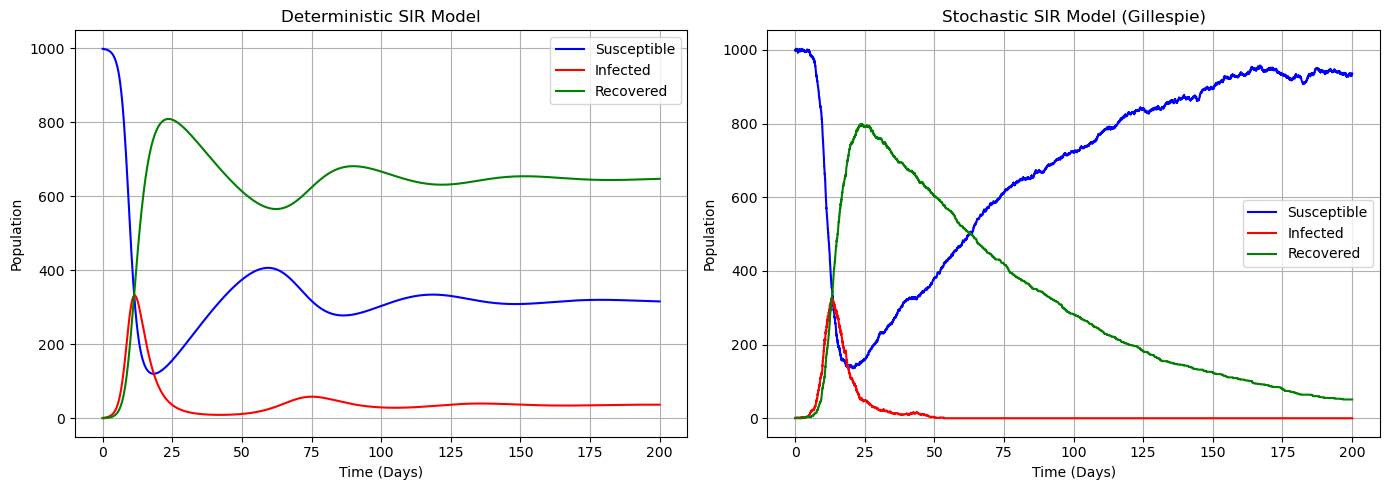

In [429]:
# Setting the parameters
tend = 200
seed = 42
start_t = 0
end_t = 200
points_t = 600

X0 = 999
Y0 = 1
Z0 = 0
N = X0 + Y0 + Z0
init_val = [X0, Y0, Z0]

beta = 1
gamma = 0.3
mu = 1/60

# Solving the deterministic model
Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)

# Solving the stochastic model using Gillespie algorithm
Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend, seed = seed)

# Plotting the figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(time, Xd, label="Susceptible", color='blue')
ax1.plot(time, Yd, label="Infected", color='red')
ax1.plot(time, Zd, label="Recovered", color='green')
ax1.set_title("Deterministic SIR Model")
ax1.set_xlabel("Time (Days)")
ax1.set_ylabel("Population")
ax1.legend(loc="best")
ax1.grid(True)

ax2.plot(t, Xs, label="Susceptible", color='blue')
ax2.plot(t, Ys, label="Infected", color='red')
ax2.plot(t, Zs, label="Recovered", color='green')
ax2.set_title("Stochastic SIR Model (Gillespie)")
ax2.set_xlabel("Time (Days)")
ax2.set_ylabel("Population")
ax2.legend(loc="best")
ax2.grid(True)

plt.tight_layout()
plt.show()

#### Functions to run multiple stochastic simulations

In [430]:
def run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend, seed=seed):
    """
    This function runs stochastic simulations (using the gillespie algorithm). 
    At each timestep time_p the mean, variance and covariance are calculated across all simulations. The number of simulations is specified in the
    'sims' variable.

    Arguments:
    sims: the number of simulations
    X0: the initial number of susceptibles
    Y0: the initial number of infected
    Z0: the initial number of recovered
    beta: infection rate
    gamma: recovery rate
    mu: birth/death rate
    tend: end time of the simulation
    seed: the used seed

    """
    
    all_Xs = [] 
    all_Ys = []  
    all_Zs = []

    time_p = np.linspace(0, tend, 200)

    for i in range(sims):
        Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, N, tend)

        # Interpolate to have consistent time points
        X_interp = np.interp(time_p, t, Xs)
        Y_interp = np.interp(time_p, t, Ys)
        Z_interp = np.interp(time_p, t, Zs)

        all_Xs.append(X_interp)
        all_Ys.append(Y_interp)
        all_Zs.append(Z_interp)

    all_Xs = np.array(all_Xs)
    all_Ys = np.array(all_Ys)
    all_Zs = np.array(all_Zs)

    return time_p, all_Xs, all_Ys, all_Zs

def mean_var_cov_stoch(all_Xs, all_Ys, all_Zs, tend):
    """
    This function computes the mean, variance and covariance of all the simulations for compartments X, Y, and Z.

    Arguments:
    all_Xs: an array of all the X values for all the simulations (size: sims x tend)
    all_Ys: an array of all the Y values for all the simulations (size: sims x tend)
    all_Zs: an array of all the Z values for all the simulations (size: sims x tend)
    tend: end time of the simulation
    """
    mean_Xs = np.mean(all_Xs, axis = 0)
    mean_Ys = np.mean(all_Ys, axis = 0)
    mean_Zs = np.mean(all_Zs, axis = 0)

    # Variability of population sizes across simulations
    var_Xs = np.var(all_Xs, axis = 0)
    var_Ys = np.var(all_Ys, axis = 0)
    var_Zs = np.var(all_Zs, axis = 0)

    cov_Xs_Ys = np.zeros(tend)

    for t in range(tend):
        cov_Xs_Ys[t] = np.mean((all_Xs[:, t] - mean_Xs[t]) * (all_Ys[:, t] - mean_Ys[t]))
    
    return mean_Xs, mean_Ys, mean_Zs, var_Xs, var_Ys, var_Zs, cov_Xs_Ys


#### Plotting mean, variance and covariance of S and I for stochastic model

In [ ]:
# Setting the parameters
sims = 50
tend = 200
seed = 42

X0 = 999
Y0 = 1
Z0 = 0
N = X0 + Y0 + Z0

beta = 1
gamma = 1/30
mu = 1/60

# Running the stochastic simulations
time_p, all_Xs, all_Ys, all_Zs = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)
mean_Xs, mean_Ys, mean_Zs, var_Xs, var_Ys, var_Zs, cov_Xs_Ys = mean_var_cov_stoch(all_Xs, all_Ys, all_Zs, tend)

print(f"Number of simulations: {sims}")
print(f"Mean of Susceptibles: {mean_Xs[-1]}")
print(f"Variance of Susceptibles: {var_Xs[-1]}")
print(f"Mean of Infected: {mean_Ys[-1]}")
print(f"Variance of Infected: {var_Ys[-1]}")

# Plotting the figures
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

std_Xs = np.std(all_Xs, axis=0)
std_Ys = np.std(all_Ys, axis=0)

axes[0].plot(time_p, mean_Xs, label='Mean Susceptible', color='blue')
axes[0].plot(time_p, mean_Ys, label='Mean Infected', color='red')
axes[0].fill_between(time_p, mean_Xs - std_Xs, mean_Xs + std_Xs, color='blue', alpha=0.2)
axes[0].fill_between(time_p, mean_Ys - std_Ys, mean_Ys + std_Ys, color='red', alpha=0.2)
axes[0].set_title("Mean Dynamics")
axes[0].set_xlabel("Time (Days)")
axes[0].set_ylabel("Population")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(time_p, var_Xs, label='Variance Susceptible', color='blue')
axes[1].plot(time_p, var_Ys, label='Variance Infected', color='red')
axes[1].set_title("Variance Dynamics")
axes[1].set_xlabel("Time (Days)")
axes[1].set_ylabel("Variance")
axes[1].legend()
axes[1].grid(True)

axes[2].plot(time_p, cov_Xs_Ys, label='Covariance (X vs Y)', color='blue')
axes[2].set_title("Covariance Dynamics (X vs Y)")
axes[2].set_xlabel("Time (Days)")
axes[2].set_ylabel("Covariance")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

# Investigate Simulation Variability and Negative Co-variance

#### Defining the functions

In [404]:
def diff_params_N(N_diff, sims, beta, gamma, mu, tend=200):
    """
    This function iterates over different values of N_diff, which is an array with different populations sizes.
    For every iteration the stochastic and deterministic models are ran, and additionally, the mean, variance, and covariance of the stochastic model
    are stored in lists. At the end these values are returned.

    Arguments:
    N_diff: numpy.linspace array that takes a starting point, end point and number of samples to generate
    sims: number of simulations 
    beta: infection rate
    gamma: recovery rate
    mu: birth/death rate
    tend: end time of the simulations
    """
    mean_deter = []  
    mean_stoch = []  
    var_stoch = []       
    cov_XYs = []      

    for N in N_diff:
        X0 = int(N) - 1   
        Y0 = 1            
        Z0 = 0            

        time_p, all_Xs, all_Ys, all_Zs = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)
        mean_Xs, mean_Ys, mean_Zs, var_Xs, var_Ys, var_Zs, cov_Xs_Ys = mean_var_cov_stoch(all_Xs, all_Ys, all_Zs, tend)
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, int(N), beta, gamma, mu, start_t, end_t, points_t)
        
        mean_deter.append(np.mean(Yd))
        mean_stoch.append(np.mean(mean_Ys))

        var_stoch.append(np.mean(var_Ys))
        cov_XYs.append(np.mean(cov_Xs_Ys)) 

    return mean_deter, mean_stoch, var_stoch, cov_XYs

def diff_params_Y0(N, Y0_diff, sims, beta, gamma, mu):
    """
    This function iterates over different values of Y0_diff, which is an array with different sizes of the infected population.
    For every iteration the stochastic and deterministic models are ran, and additionally, the mean, variance, and covariance of the stochastic model
    are stored in lists. At the end these values are returned.

    Arguments:
    N: the total size of the population
    Y0_diff: numpy.linspace array that takes a starting point, end point and number of samples to generate
    sims: number of simulations 
    beta: infection rate
    gamma: recovery rate
    mu: birth/death rate
    """
    mean_deter = []  
    mean_stoch = []  
    var_Y = []       
    cov_XY = []      

    for y0 in Y0_diff:
        X0 = N - y0  
        Y0 = y0      
        Z0 = 0    
        
        time_p, all_Xs, all_Ys, all_Zs = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        mean_Xs, mean_Ys, mean_Zs, var_Xs, var_Ys, var_Zs, cov_Xs_Ys = mean_var_cov_stoch(all_Xs, all_Ys, all_Zs, tend)
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        mean_deter.append(np.mean(Yd))  
        mean_stoch.append(np.mean(mean_Ys))  
        
        var_Y.append(np.mean(var_Ys))  
        cov_XY.append(np.mean(cov_Xs_Ys)) 
    
    return mean_deter, mean_stoch, var_Y, cov_XY

def diff_params_beta(N, sims, beta_diff, gamma, mu, X0, Y0, Z0):
    """
    This function iterates over different values of beta_diff, which is an array with different values of beta, the infection rate.
    For every iteration the stochastic and deterministic models are ran, and additionally, the mean, variance, and covariance of the stochastic model
    are stored in lists. At the end these values are returned.

    Arguments:
    N: the total size of the population
    beta_diff: numpy.linspace array that takes a starting point, end point and number of samples to generate
    sims: number of simulations 
    gamma: recovery rate
    mu: birth/death rate
    X0: number of susceptible individuals
    Y0: number of infected individuals
    Z0: number of recovered individuals
    """
    
    mean_deter = []  
    mean_stoch = []  
    var_Y = []       
    cov_XY = []     

    for beta in beta_diff:
        time_p, all_Xs, all_Ys, all_Zs = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=200)
        mean_Xs, mean_Ys, mean_Zs, var_Xs, var_Ys, var_Zs, cov_Xs_Ys = mean_var_cov_stoch(all_Xs, all_Ys, all_Zs, tend)
        Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=200, points_t=200)
        
        mean_deter.append(np.mean(Yd))  
        mean_stoch.append(np.mean(mean_Ys)) 
        
        var_Y.append(np.mean(var_Ys)) 
        cov_XY.append(np.mean(cov_Xs_Ys))

    return mean_deter, mean_stoch, var_Y, cov_XY, time_p, all_Ys

def diff_params_gamma(N, sims, beta, gamma_diff, mu, X0, Y0, Z0, tend=200, points_t=200):
    """
    This function iterates over different values of gamma_diff, which is an array with different values of gamma, the recovery rate.
    For every iteration the stochastic and deterministic models are ran, and additionally, the mean, variance, and covariance of the stochastic model
    are stored in lists. At the end these values are returned.

    Arguments:
    N: total size of the population
    gamma_diff: numpy.linspace array that takes a starting point, end point and number of samples to generate
    sims: number of simulations 
    beta: infection rate
    mu: birth/death rate
    X0: number of susceptible individuals
    Y0: number of infected individuals
    Z0: number of recovered individuals
    tend: end time of the simulations, set at 200
    points_t: parameter in the numpy.linspace function which sets the number of samples to generate, set at 200
    """
    
    mean_deter = []
    mean_stoch = [] 
    var_Y = []       
    cov_XY = []     
    time_p = np.linspace(0, tend, points_t)  # Ensure consistent time points
    
    for gamma in gamma_diff:
        time_p, all_Xs, all_Ys, all_Zs = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=tend)
        mean_Xs, mean_Ys, mean_Zs, var_Xs, var_Ys, var_Zs, cov_Xs_Ys = mean_var_cov_stoch(all_Xs, all_Ys, all_Zs, len(time_p))
        Xd, Yd, Zd, time_det, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=tend, points_t=points_t)
        
        mean_deter.append(np.mean(Yd))  
        mean_stoch.append(np.mean(mean_Ys))
        
        var_Y.append(np.mean(var_Ys)) 
        cov_XY.append(np.mean(cov_Xs_Ys))

    return mean_deter, mean_stoch, var_Y, cov_XY

def diff_params_mu(N, sims, beta, gamma, mu_diff, X0, Y0, Z0, tend=200, points_t=200):
    """
    This function iterates over different values of mu_diff, which is an array with different values of mu, the birth/death rate.
    For every iteration the stochastic and deterministic models are ran, and additionally, the mean, variance, and covariance of the stochastic model
    are stored in lists. At the end these values are returned.

    Arguments:
    N: total size of the population
    mu_diff: numpy.linspace array that takes a starting point, end point and number of samples to generate
    sims: number of simulations 
    beta: infection rate
    gamma: recovery rate
    X0: number of susceptible individuals
    Y0: number of infected individuals
    Z0: number of recovered individuals
    tend: end time of the simulations, set at 200
    points_t: parameter in the numpy.linspace function which sets the number of samples to generate, set at 200
    """    
    mean_deter = []  
    mean_stoch = []  
    var_Y = []       
    cov_XY = []     

    # Ensure consistent time points
    time_p = np.linspace(0, tend, points_t)

    for mu in mu_diff:
        time_p, all_Xs, all_Ys, all_Zs = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend=tend)
        mean_Xs, mean_Ys, mean_Zs, var_Xs, var_Ys, var_Zs, cov_Xs_Ys = mean_var_cov_stoch(all_Xs, all_Ys, all_Zs, len(time_p))
        Xd, Yd, Zd, time_det, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t=0, end_t=tend, points_t=points_t)
        
        mean_deter.append(np.mean(Yd))  
        mean_stoch.append(np.mean(mean_Ys))  
        
        var_Y.append(np.mean(var_Ys)) 
        cov_XY.append(np.mean(cov_Xs_Ys))

    return mean_deter, mean_stoch, var_Y, cov_XY



#### Varying N

In [ ]:
# Setting the parameters
N_diff = np.linspace(10, 10000, 100)
sims = 30 
beta = 1
gamma = 1/3
mu = 1/6
tend = 200
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Running the simulations
mean_deter, mean_stoch, var_stoch, cov_XYs = diff_params_N(N_diff, sims, beta, gamma, mu, tend)

# Plotting the figures
axes[0].plot(N_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
axes[0].plot(N_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
axes[0].set_title("Mean of Deterministic and Stochastic SIR for varying N")
axes[0].set_xlabel("Population Size (N)")
axes[0].set_ylabel("Mean Infectious Population")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(N_diff, var_stoch, label='Variance of Stochastic Y', color='green')  # Variance over N
axes[1].set_title("Variance of Infectious Population")
axes[1].set_xlabel("Population Size (N)")
axes[1].set_ylabel("Mean Variance of Y")
axes[1].grid(True)
axes[1].legend()

axes[2].plot(N_diff, cov_XYs, label='Covariance in Stochastic SIR', color='purple')  # Covariance over N
axes[2].set_title("Covariance Dynamics of SIR")
axes[2].set_xlabel("Population Size (N)")
axes[2].set_ylabel("Mean Covariance (X vs Y)")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()




#### Varying Y0 (initial number of infectious individuals)

In [ ]:
# Setting the parameters
N = 10000
Y0_diff = np.linspace(1, 10000, 100)
beta = 1
gamma = 1/3
mu = 1/60
sims = 30

# Running the simulations
mean_deter, mean_stoch, var_Y, cov_XY = diff_params_Y0(N, Y0_diff, sims, beta, gamma, mu)

# Initialize plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting figures
axes[0].plot(Y0_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
axes[0].plot(Y0_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
axes[0].set_title("Mean of Deterministic and Stochastic SIR for varying Y0")
axes[0].set_xlabel("Initial Infected Population (Y0)")
axes[0].set_ylabel("Mean Infectious Population")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(Y0_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over Y0
axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
axes[1].set_xlabel("Initial Infected Population (Y0)")
axes[1].set_ylabel("Mean Variance of Y")
axes[1].grid(True)
axes[1].legend()

axes[2].plot(Y0_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over Y0
axes[2].set_title("Covariance Dynamics of Stochastic SIR")
axes[2].set_xlabel("Initial Infected Population (Y0)")
axes[2].set_ylabel("Mean Covariance (X vs Y)")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()



#### Varying beta

In [ ]:
# Setting the parameters
N = 10000
beta_diff = np.linspace(0, 10, 100)
gamma = 1/3
mu = 1/60
X0 = 9999
Y0 = 1
Z0 = 0
sims = 30

# Initialize plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

mean_deter, mean_stoch, var_Y, cov_XY, time_p, all_Ys = diff_params_beta(N, sims, beta_diff, gamma, mu, X0, Y0, Z0)

# Plotting the figures
axes[0].plot(beta_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  
axes[0].plot(beta_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     
axes[0].set_title("Mean of Deterministic and Stochastic SIR for varying beta")
axes[0].set_xlabel("Transmission Rate (Beta)")
axes[0].set_ylabel("Mean Infectious Population")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(beta_diff, var_Y, label='Variance of Stochastic Y', color='green') 
axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
axes[1].set_xlabel("Transmission Rate (Beta)")
axes[1].set_ylabel("Mean Variance of Y")
axes[1].grid(True)
axes[1].legend()

axes[2].plot(beta_diff, cov_XY, label='Covariance between X and Y', color='purple')  
axes[2].set_title("Covariance Dynamics of Stochastic SIR")
axes[2].set_xlabel("Transmission Rate (Beta)")
axes[2].set_ylabel("Mean Covariance (X vs Y)")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()



#### Varying gamma 

In [ ]:
# Setting the parameters
N = 10000
beta = 1
gamma_diff = np.linspace(0.01, 1, 100)
mu = 1/60
X0 = 9999
Y0 = 1
Z0 = 0
sims = 30

# Running the simulations
mean_deter, mean_stoch, var_Y, cov_XY = diff_params_gamma(N, sims, beta, gamma_diff, mu, X0, Y0, Z0)

# Initialize plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting figures
axes[0].plot(gamma_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
axes[0].plot(gamma_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
axes[0].set_title("Mean of Deterministic and Stochastic SIR for varying gamma")
axes[0].set_xlabel("Recovery Rate (Gamma)")
axes[0].set_ylabel("Mean Infectious Population")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(gamma_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over gamma
axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
axes[1].set_xlabel("Recovery Rate (Gamma)")
axes[1].set_ylabel("Mean Variance of Y")
axes[1].grid(True)
axes[1].legend()

axes[2].plot(gamma_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over gamma
axes[2].set_title("Covariance Dynamics of Stochastic SIR")
axes[2].set_xlabel("Recovery Rate (Gamma)")
axes[2].set_ylabel("Mean Covariance (X vs Y)")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()


#### Varying mu (birth rate)

In [ ]:
# Setting the parameters
N = 10000
beta = 1
gamma = 1/3
mu_diff = np.linspace(0.01, 0.5, 100)
X0 = 9999
Y0 = 1
Z0 = 0
sims = 20
tend = 200
points_t = 200

# Running the simulations
mean_deter, mean_stoch, var_Y, cov_XY = diff_params_mu(N, sims, beta, gamma, mu_diff, X0, Y0, Z0, tend=tend, points_t=points_t)

# Initialize plots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the figures
axes[0].plot(mu_diff, mean_deter, label='Mean of Deterministic SIR', color='blue')  # Deterministic mean
axes[0].plot(mu_diff, mean_stoch, label='Mean of Stochastic SIR', color='red')     # Stochastic mean
axes[0].set_title("Mean of Deterministic vs Stochastic SIR (Infectious) over Different Mu Values")
axes[0].set_xlabel("Natural Death Rate (Mu)")
axes[0].set_ylabel("Mean Infectious Population")
axes[0].grid(True)
axes[0].legend()

axes[1].plot(mu_diff, var_Y, label='Variance of Stochastic Y', color='green')  # Variance over mu
axes[1].set_title("Variance of Infectious Population in Stochastic SIR")
axes[1].set_xlabel("Natural Death Rate (Mu)")
axes[1].set_ylabel("Mean Variance of Y")
axes[1].grid(True)
axes[1].legend()

axes[2].plot(mu_diff, cov_XY, label='Covariance between X and Y', color='purple')  # Covariance over mu
axes[2].set_title("Covariance Dynamics of Stochastic SIR")
axes[2].set_xlabel("Natural Death Rate (Mu)")
axes[2].set_ylabel("Mean Covariance (X vs Y)")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()


# Stochastic Resonance and Increased Transient

In [ ]:
N = [50, 200, 500, 1000]
beta = 1
gamma = 1 / 60
mu = 1 / 30
start_t = 0
end_t = 1000
points_t = 1000
sims = 20
tend = 1000

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, n in enumerate(N):
    X0 = n - 1
    Y0 = 1
    Z0 = 0

    # Deterministic simulation
    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, n, beta, gamma, mu, start_t, end_t, points_t)
    
    # Stochastic simulation
    time_p, all_Xs, all_Ys, all_Zs = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, n, tend)
    mean_Xs, mean_Ys, mean_Zs, var_Xs, var_Ys, var_Zs, cov_Xs_Ys = mean_var_cov_stoch(all_Xs, all_Ys, all_Zs, len(time_p))
    
    # Plot deterministic results
    axs[i // 2, i % 2].plot(time, Xd, 'b--', label="Deterministic Susceptible")
    axs[i // 2, i % 2].plot(time, Yd, 'r--', label="Deterministic Infected")
    
    # Plot stochastic results
    axs[i // 2, i % 2].plot(time_p, mean_Xs, 'b', label=f"Mean Stochastic Susceptible")
    axs[i // 2, i % 2].plot(time_p, mean_Ys, 'r', label=f"Mean Stochastic Infected")
    
    # Plot variance as shaded area
    axs[i // 2, i % 2].fill_between(time_p, 
                                     mean_Ys - np.sqrt(var_Ys), 
                                     mean_Ys + np.sqrt(var_Ys), 
                                     color='red', alpha=0.2, label='Variance of Infected')
    
    # Title, labels, and grid
    axs[i // 2, i % 2].set_title(f"SIR Comparison (N={n})")
    axs[i // 2, i % 2].set_xlabel("Time (days)")
    axs[i // 2, i % 2].set_ylabel("Population")
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()


In [ ]:
beta_values = [1 / 5, 1 / 2, 1, 2]  # Different values for beta
gamma = 1 / 60
mu = 1 / 30
start_t = 0
end_t = 1000
points_t = 1000
sims = 20
tend = 1000
N = 1000
X0 = 999
Y0 = 1
Z0 = 0

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, beta in enumerate(beta_values):

    # Run deterministic solution
    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)
    
    # Run stochastic simulations
    time_p, all_Xs, all_Ys, all_Zs = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)
    mean_Xs, mean_Ys, mean_Zs, var_Xs, var_Ys, var_Zs, cov_Xs_Ys = mean_var_cov_stoch(all_Xs, all_Ys, all_Zs, len(time_p))
    
    # Plot deterministic results
    axs[i // 2, i % 2].plot(time, Xd, 'b--', label="Deterministic Susceptible")
    axs[i // 2, i % 2].plot(time, Yd, 'r--', label="Deterministic Infected")
    
    # Plot stochastic results
    axs[i // 2, i % 2].plot(time_p, mean_Xs, 'b', label=f"Mean Stochastic Susceptible")
    axs[i // 2, i % 2].plot(time_p, mean_Ys, 'r', label=f"Mean Stochastic Infected")
    
    # Plot variance as shaded area
    axs[i // 2, i % 2].fill_between(time_p, 
                                     mean_Ys - np.sqrt(var_Ys), 
                                     mean_Ys + np.sqrt(var_Ys), 
                                     color='red', alpha=0.2, label='Variance of Infected')
    
    # Title, labels, and grid
    axs[i // 2, i % 2].set_title(f"SIR Comparison (β={beta})")
    axs[i // 2, i % 2].set_xlabel("Time (days)")
    axs[i // 2, i % 2].set_ylabel("Population")
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()


In [ ]:
gamma_values = [1 / 10, 1 / 5, 1 / 2, 0.8 ]  # Different values for gamma
N = 1000 
beta = 0.5
mu = 1 / 30
start_t = 0
end_t = 500
points_t = 500
sims = 20
tend = 500
X0 = 999
Y0 = 1
Z0 = 0

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, gamma in enumerate(gamma_values):

    # Run deterministic model
    Xd, Yd, Zd, time, R0_det = deterSol(X0, Y0, Z0, N, beta, gamma, mu, start_t, end_t, points_t)
    
    # Run stochastic simulations
    time_p, all_Xs, all_Ys, all_Zs = run_stoch_sim(sims, X0, Y0, Z0, beta, gamma, mu, N, tend)
    mean_Xs, mean_Ys, mean_Zs, var_Xs, var_Ys, var_Zs, cov_Xs_Ys = mean_var_cov_stoch(all_Xs, all_Ys, all_Zs, len(time_p))

    # Plot deterministic results
    axs[i // 2, i % 2].plot(time, Xd, 'b--', label="Deterministic Susceptible")
    axs[i // 2, i % 2].plot(time, Yd, 'r--', label="Deterministic Infected")
    
    # Plot stochastic results
    axs[i // 2, i % 2].plot(time_p, mean_Xs, 'b', label=f"Mean Stochastic Susceptible")
    axs[i // 2, i % 2].plot(time_p, mean_Ys, 'r', label=f"Mean Stochastic Infected")
    
    # Plot variance as shaded area
    axs[i // 2, i % 2].fill_between(time_p, 
                                     mean_Ys - np.sqrt(var_Ys), 
                                     mean_Ys + np.sqrt(var_Ys), 
                                     color='red', alpha=0.2, label='Variance of Infected')
    
    # Title, labels, and grid
    axs[i // 2, i % 2].set_title(f"SIR Comparison (γ={gamma})")
    axs[i // 2, i % 2].set_xlabel("Time (days)")
    axs[i // 2, i % 2].set_ylabel("Population")
    axs[i // 2, i % 2].legend()
    axs[i // 2, i % 2].grid()

plt.tight_layout()
plt.show()


# Extinction event (different R0, fixed population size N)

#### Functions to run the simulations for N and R0

In [421]:
def calc_ext_prob(R0):
    """Calculate the extinction probability given R0, and ensure it's clipped to the [0, 1] range."""
    return np.clip(1 / R0, 0, 1)

def run_simulation_and_plotN(param_diff, param_name, sims_ext, beta_const, gamma_const, mu_const, t_end, X0, Y0, Z0, vary_params=False):
    """
    General function to run simulations and plot extinction statistics.
    
    Args:
    param_diff: Array of different values of N or R0.
    param_name: Name of the parameter being varied ("N" or "R0").
    sims_ext: Number of simulations to run for each parameter value.
    beta_const, gamma_const, mu_const: Constant transmission, recovery, and death rates.
    t_end: End time for the simulation.
    X0, Y0, Z0: Initial conditions (susceptible, infected, recovered).
    vary_params: If True, vary beta, gamma, and mu for each N.
    
    Returns:
    - Sorted parameter values and corresponding extinction data (for further plotting).
    """
    # Initialize lists to store results
    Ys_ext2 = []  # Average extinction times
    extinction_counts = []  # Number of extinctions for each parameter value
    probabilities = []  # Extinction probabilities for each parameter value

    # Loop over different values of the parameter (N or R0)
    for i, param in enumerate(param_diff):
        Ys_sim = []  # Temporary list to store extinction times for each simulation
        ext_count = 0  # Counter for the number of extinctions

        # Vary parameters if necessary
        if vary_params:
            beta = np.random.uniform(0.1, 4)  # Vary beta randomly
            gamma = np.random.uniform(0.01, 1)   # Vary gamma randomly
            mu = np.random.uniform(0.01, 0.5)   # Vary mu randomly
            R0 = beta / (gamma + mu)  # Calculate new R0 for each N when varying parameters
        else:
            beta, gamma, mu = beta_const, gamma_const, mu_const  # Keep beta, gamma, mu constant
            R0 = beta / (gamma + mu)  # Fixed R0 based on constant parameters

        # Clip R0 if it's too small to avoid probabilities > 1
        if R0 < 1:
            R0 = 1.01  # Ensure R0 stays slightly above 1

        # Loop over simulations
        for sim in range(sims_ext):
            # Adjust X0 if simulating for different N values
            if param_name == "N":
                X0 = int(param) - 1  # Susceptible individuals (N-1)

            # Run the simulation using the gillespie_sir function (assuming it exists in your environment)
            Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, X0 + Y0 + Z0, tend=t_end, seed=sim)

            # Find the index of the first 0 in the Ys (extinction time)
            if 0 in Ys:
                extinction_time = Ys.index(0)
                Ys_sim.append(extinction_time)  # Only append if extinction happens
                ext_count += 1  # Increment extinction count if extinction occurs

        # Calculate the average extinction time only if there were extinctions
        if Ys_sim:
            average_extinction_time = sum(Ys_sim) / len(Ys_sim)
            Ys_ext2.append(average_extinction_time)
        else:
            Ys_ext2.append(np.nan)  # If no extinctions, append NaN

        # Append results for this parameter value
        extinction_counts.append(ext_count)  # Store the number of extinctions for this parameter
        probabilities.append(calc_ext_prob(R0))  # Store the calculated probability for this parameter

        print(f'For {param_name} = {param}, total extinctions = {ext_count}, average extinction time = {Ys_ext2[-1]}, extinction probability = {probabilities[-1]}')

    # Sort the parameter values and corresponding data
    sorted_indices = np.argsort(param_diff)
    param_diff_sorted = np.array(param_diff)[sorted_indices]
    Ys_ext2_sorted = np.array(Ys_ext2)[sorted_indices]
    extinction_counts_sorted = np.array(extinction_counts)[sorted_indices]
    probabilities_sorted = np.array(probabilities)[sorted_indices]

    return param_diff_sorted, Ys_ext2_sorted, extinction_counts_sorted, probabilities_sorted

def run_simulation_and_plot_r0(param_diff, param_name, sims_ext, beta_ext, gamma_ext, mu_ext, t_end, X0, Y0, Z0):
    """
    General function to run simulations and plot extinction statistics for varying R0.
    
    Arguments:
    param_diff: Array of different values of R0.
    param_name: Name of the parameter being varied ("R0").
    sims_ext: Number of simulations to run for each parameter value.
    beta_ext, gamma_ext, mu_ext: Arrays of transmission, recovery, and death rates.
    t_end: End time for the simulation.
    X0, Y0, Z0: Initial conditions (susceptible, infected, recovered).
    
    Returns:
    - Sorted parameter values and corresponding extinction data (for further plotting).
    """
    # Initialize lists to store results
    Ys_ext2 = []  # Average extinction times
    extinction_counts = []  # Number of extinctions for each parameter value
    probabilities = []  # Extinction probabilities for each parameter value

    # Loop over different values of R0
    for i, R0 in enumerate(param_diff):
        Ys_sim = []  # Temporary list to store extinction times for each simulation
        ext_count = 0  # Counter for the number of extinctions

        beta = R0 * (gamma_ext[i % len(gamma_ext)] + mu_ext[i % len(mu_ext)])  # Calculate beta for given R0
        gamma = gamma_ext[i % len(gamma_ext)]  # Recovery rate
        mu = mu_ext[i % len(mu_ext)]  # Death rate

        # Loop over simulations
        for sim in range(sims_ext):
            # Run the simulation using the gillespie_sir function (assuming it exists in your environment)
            Xs, Ys, Zs, t, R0_stoch = gillespie_sir(X0, Y0, Z0, beta, gamma, mu, X0 + Y0 + Z0, tend=t_end, seed=sim)

            # Find the index of the first 0 in the Ys (extinction time)
            if 0 in Ys:
                extinction_time = Ys.index(0)
                Ys_sim.append(extinction_time)  # Only append if extinction happens
                ext_count += 1  # Increment extinction count if extinction occurs

        # Calculate the average extinction time only if there were extinctions
        if Ys_sim:
            average_extinction_time = sum(Ys_sim) / len(Ys_sim)
            Ys_ext2.append(average_extinction_time)
        else:
            Ys_ext2.append(np.nan)  # If no extinctions, append NaN

        # Append results for this parameter value
        extinction_counts.append(ext_count)  # Store the number of extinctions for this parameter
        probabilities.append(calc_ext_prob(R0))  # Store the calculated probability for this parameter

        print(f'For {param_name} = {R0}, total extinctions = {ext_count}, average extinction time = {Ys_ext2[-1]}, extinction probability = {probabilities[-1]}')

    # Sort the parameter values and corresponding data
    sorted_indices = np.argsort(param_diff)
    param_diff_sorted = np.array(param_diff)[sorted_indices]
    Ys_ext2_sorted = np.array(Ys_ext2)[sorted_indices]
    extinction_counts_sorted = np.array(extinction_counts)[sorted_indices]
    probabilities_sorted = np.array(probabilities)[sorted_indices]

    return param_diff_sorted, Ys_ext2_sorted, extinction_counts_sorted, probabilities_sorted

#### Plotting N with constant and varying parameters

In [ ]:
# Setting the parameters
sims_ext = 30  
beta_const = 1  
gamma_const = 1/3  
mu_const = 1/60 
t_end = 365 

N_diff = np.linspace(1000, 10000, 10) 
X0 = 999 
Y0 = 1 
Z0 = 0

# Running the simulations for constant and varying parameters
N_sorted_const, Ys_ext2_N_const_sorted, extinction_counts_N_const_sorted, probabilities_N_const_sorted = run_simulation_and_plotN(N_diff, "N", sims_ext, beta_const, gamma_const, mu_const, t_end, X0, Y0, Z0)
N_sorted_vary, Ys_ext2_N_vary_sorted, extinction_counts_N_vary_sorted, probabilities_N_vary_sorted = run_simulation_and_plotN(N_diff, "N", sims_ext, beta_const, gamma_const, mu_const, t_end, X0, Y0, Z0, vary_params=True)

# Initializing plots
fig, ax = plt.subplots(3, 2, figsize=(16, 12))

# Plotting figures
ax[0, 0].plot(N_sorted_const, probabilities_N_const_sorted, marker='o', color='red', label='Extinction Probability (N, constant params)')
ax[0, 0].set_title("Extinction Probability vs N (constant params)")
ax[0, 0].set_xlabel("Population Size (N)")
ax[0, 0].set_ylabel("Extinction Probability")
ax[0, 0].grid(True)
ax[0, 0].legend()

ax[1, 0].plot(N_sorted_const, extinction_counts_N_const_sorted, marker='o', color='green', label='Number of Extinctions (N, constant params)')
ax[1, 0].set_title("Total Number of Extinctions vs N (constant params)")
ax[1, 0].set_xlabel("Population Size (N)")
ax[1, 0].set_ylabel("Total Number of Extinctions")
ax[1, 0].grid(True)
ax[1, 0].legend()

ax[2, 0].plot(N_sorted_const, Ys_ext2_N_const_sorted, marker='o', color='blue', label='Avg Extinction Time (N, constant params)')
ax[2, 0].set_title("Average Extinction Time vs N (constant params)")
ax[2, 0].set_xlabel("Population Size (N)")
ax[2, 0].set_ylabel("Average Time to Extinction")
ax[2, 0].grid(True)
ax[2, 0].legend()

ax[0, 1].plot(N_sorted_vary, probabilities_N_vary_sorted, marker='o', color='red', label='Extinction Probability (N, varying params)')
ax[0, 1].set_title("Extinction Probability vs N (varying params)")
ax[0, 1].set_xlabel("Population Size (N)")
ax[0, 1].set_ylabel("Extinction Probability")
ax[0, 1].grid(True)
ax[0, 1].legend()

ax[1, 1].plot(N_sorted_vary, extinction_counts_N_vary_sorted, marker='o', color='green', label='Number of Extinctions (N, varying params)')
ax[1, 1].set_title("Total Number of Extinctions vs N (varying params)")
ax[1, 1].set_xlabel("Population Size (N)")
ax[1, 1].set_ylabel("Total Number of Extinctions")
ax[1, 1].grid(True)
ax[1, 1].legend()

ax[2, 1].plot(N_sorted_vary, Ys_ext2_N_vary_sorted, marker='o', color='blue', label='Avg Extinction Time (N, varying params)')
ax[2, 1].set_title("Average Extinction Time vs N (varying params)")
ax[2, 1].set_xlabel("Population Size (N)")
ax[2, 1].set_ylabel("Average Time to Extinction")
ax[2, 1].grid(True)
ax[2, 1].legend()

plt.tight_layout()
plt.show()


#### Plotting figures for R0 with N=2000 and N=10000

In [ ]:
# Setting the parameters
sims_ext = 10  
gamma_ext = np.linspace(0.01, 1, sims_ext)  
mu_ext = np.linspace(0.01, 0.5, sims_ext)
t_end = 365 

R0_diff = np.linspace(1.1, 5, 10)  # Vary R0 values directly

X0_2000 = 2000 - 1  
X0_10000 = 10000 - 1
Y0 = 1  
Z0 = 0 

R0_sorted_2000, Ys_ext2_R0_sorted_2000, extinction_counts_R0_sorted_2000, probabilities_R0_sorted_2000 = run_simulation_and_plot_r0(
    R0_diff, "R0", sims_ext, None, gamma_ext, mu_ext, t_end, X0_2000, Y0, Z0)

R0_sorted_10000, Ys_ext2_R0_sorted_10000, extinction_counts_R0_sorted_10000, probabilities_R0_sorted_10000 = run_simulation_and_plot_r0(
    R0_diff, "R0", sims_ext, None, gamma_ext, mu_ext, t_end, X0_10000, Y0, Z0)

# Initializing plots
fig, ax = plt.subplots(3, 2, figsize=(16, 12))

# Plotting the figures
ax[0, 0].plot(R0_sorted_2000, probabilities_R0_sorted_2000, marker='o', color='red', label='Extinction Probability (R0, N=2000)')
ax[0, 0].set_title("Extinction Probability vs R0 (N=2000)")
ax[0, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[0, 0].set_ylabel("Extinction Probability")
ax[0, 0].grid(True)
ax[0, 0].legend()

ax[1, 0].plot(R0_sorted_2000, extinction_counts_R0_sorted_2000, marker='o', color='green', label='Number of Extinctions (R0, N=2000)')
ax[1, 0].set_title("Total Number of Extinctions vs R0 (N=2000)")
ax[1, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 0].set_ylabel("Total Number of Extinctions")
ax[1, 0].grid(True)
ax[1, 0].legend()

ax[2, 0].plot(R0_sorted_2000, Ys_ext2_R0_sorted_2000, marker='o', color='blue', label='Avg Extinction Time (R0, N=2000)')
ax[2, 0].set_title("Average Extinction Time vs R0 (N=2000)")
ax[2, 0].set_xlabel("R0 (Basic Reproduction Number)")
ax[2, 0].set_ylabel("Average Time to Extinction")
ax[2, 0].grid(True)
ax[2, 0].legend()

ax[0, 1].plot(R0_sorted_10000, probabilities_R0_sorted_10000, marker='o', color='red', label='Extinction Probability (R0, N=10000)')
ax[0, 1].set_title("Extinction Probability vs R0 (N=10000)")
ax[0, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[0, 1].set_ylabel("Extinction Probability")
ax[0, 1].grid(True)
ax[0, 1].legend()

ax[1, 1].plot(R0_sorted_10000, extinction_counts_R0_sorted_10000, marker='o', color='green', label='Number of Extinctions (R0, N=10000)')
ax[1, 1].set_title("Total Number of Extinctions vs R0 (N=10000)")
ax[1, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[1, 1].set_ylabel("Total Number of Extinctions")
ax[1, 1].grid(True)
ax[1, 1].legend()

ax[2, 1].plot(R0_sorted_10000, Ys_ext2_R0_sorted_10000, marker='o', color='blue', label='Avg Extinction Time (R0, N=10000)')
ax[2, 1].set_title("Average Extinction Time vs R0 (N=10000)")
ax[2, 1].set_xlabel("R0 (Basic Reproduction Number)")
ax[2, 1].set_ylabel("Average Time to Extinction")
ax[2, 1].grid(True)
ax[2, 1].legend()

plt.tight_layout()
plt.show()


# Problem 2


#### 2.1 Implement SIR and Simulate

In [ ]:
output_notebook()

# Function to generate networks
def generate_networks(nodes, edge_prob_erdos, edge_prob_watts, k_connections_watts, nr_edges_barb):
    erdos = nx.erdos_renyi_graph(nodes, edge_prob_erdos)
    watts = nx.watts_strogatz_graph(nodes, k_connections_watts, edge_prob_watts)
    barabasi = nx.barabasi_albert_graph(nodes, nr_edges_barb)
    return [erdos, watts, barabasi]

# Function to run SIR model on a given network
def run_sir_model(network, beta, gamma, fraction_infected, num_iterations = 50):
    model = ep.SIRModel(network)
    
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)
    cfg.add_model_parameter('fraction_infected', fraction_infected)
    model.set_initial_status(cfg)

    simulations = model.iteration_bunch(num_iterations)
    
    iterations = [sim['iteration'] for sim in simulations]
    susceptible = [sim['node_count'][0] for sim in simulations]
    infected = [sim['node_count'][1] for sim in simulations]
    recovered = [sim['node_count'][2] for sim in simulations]
    
    return iterations, susceptible, infected, recovered

def plot_results(networks, results, titles):
    plots = []
    prevalence_plots = []
    for idx, (iterations, susceptible, infected_counts, recovered) in enumerate(results):

        p = figure(title=titles[idx], x_axis_label='Iterations', y_axis_label='Number of Individuals', width=400, height=400)
        
        p.line(iterations, susceptible, legend_label='Susceptible', color='blue', line_width=2)
        p.line(iterations, infected_counts, legend_label='Infected', color='red', line_width=2)
        p.line(iterations, recovered, legend_label='Recovered', color='green', line_width=2)
        
        p.legend.title = "States"
        p.legend.location = "top_right"
        
        plots.append(p)

        # Compute prevalence of Infectious individuals
        total_population = susceptible[0] + infected_counts[0] + recovered[0]
        prevalence = [i / total_population for i in infected_counts]

        prevalence_plot = figure(title=f"{titles[idx]} - Prevalence", x_axis_label='Iterations', y_axis_label='Proportion Infected',
                                 width=400, height=400)

        prevalence_plot.line(iterations, prevalence, legend_label='Prevalence', color='purple', line_width=2)
        prevalence_plot.legend.location = "top_right"
        
        prevalence_plots.append(prevalence_plot)

    grid = gridplot([[plots[0], plots[1], plots[2]], [prevalence_plots[0], prevalence_plots[1], prevalence_plots[2]]])
    show(grid)

# Function to run multiple simulations across networks
def run_networks(beta, gamma, fraction_infected, nodes, edge_prob_erdos, edge_prob_watts, k_connections_watts, nr_edges_barb, repetitions, num_iterations = 50, seed=None):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    networks = generate_networks(nodes, edge_prob_erdos, edge_prob_watts, k_connections_watts, nr_edges_barb)
    titles = ['Erdos-Renyi SIR Network', 'Watts-Strogatz SIR Network', 'Barabasi-Albert SIR Network']
    results = []
    
    # Repeat the simulation across each network for the given number of repetitions
    for network in networks:
        all_susceptible = np.zeros(num_iterations)
        all_infected = np.zeros(num_iterations)
        all_recovered = np.zeros(num_iterations)

        for _ in range(repetitions):
            iterations, susceptible, infected, recovered = run_sir_model(network, beta, gamma, fraction_infected)
            all_susceptible += np.array(susceptible)
            all_infected += np.array(infected)
            all_recovered += np.array(recovered)

        avg_susceptible = all_susceptible / repetitions
        avg_infected = all_infected / repetitions
        avg_recovered = all_recovered / repetitions
        
        results.append((iterations, avg_susceptible, avg_infected, avg_recovered))

    plot_results(networks, results, titles)

In [ ]:
run_networks(beta=1, gamma = 1/3, fraction_infected=0.02, nodes=1000, edge_prob_erdos=0.1, edge_prob_watts=0.1, k_connections_watts=4, nr_edges_barb=2, repetitions=40, seed=42)

#### 2.2 Generate Networks of equivalent form

In [4]:
# Function to generate and plot network models, degree distributions, and centralities
def generate_and_plot_networks_with_centralities(nodes, k, p_watts, m_barabasi, p_erdos, seed=None):
    # Set seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)  # Seed numpy as well for further consistency
    
    # Generate the networks
    watts = nx.watts_strogatz_graph(nodes, k, p_watts, seed=seed)
    barabasi = nx.barabasi_albert_graph(nodes, m_barabasi, seed=seed)
    erdos = nx.erdos_renyi_graph(nodes, p_erdos, seed=seed)

    # Plot the networks
    plt.figure(figsize=(18, 6))
    
    # Watts-Strogatz
    plt.subplot(1, 3, 1)
    nx.draw(watts, with_labels=True, node_color='skyblue', node_size=700, font_size=10)
    plt.title(f'Watts-Strogatz ($k={k}, p={p_watts}$)')

    # Barabási-Albert
    plt.subplot(1, 3, 2)
    nx.draw(barabasi, with_labels=True, node_color='skyblue', node_size=700, font_size=10)
    plt.title(f'Barabási-Albert ($m={m_barabasi}$)')

    # Erdős-Rényi
    plt.subplot(1, 3, 3)
    nx.draw(erdos, with_labels=True, node_color='skyblue', node_size=700, font_size=10)
    plt.title(f'Erdős-Rényi ($p={p_erdos}$)')
    
    plt.tight_layout()
    plt.show()

    # Plot the degree distributions
    plt.figure(figsize=(18, 6))
    
    # Watts-Strogatz Degree Distribution
    plt.subplot(1, 3, 1)
    watts_degrees = [d for n, d in watts.degree()]
    sns.histplot(watts_degrees, bins=10)
    plt.title(f'Watts-Strogatz Degree Distribution\n$k={k}, p={p_watts}$')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')

    # Barabási-Albert Degree Distribution
    plt.subplot(1, 3, 2)
    barabasi_degrees = [d for n, d in barabasi.degree()]
    sns.histplot(barabasi_degrees, bins=10)
    plt.title(f'Barabási-Albert Degree Distribution\n$m={m_barabasi}$')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')

    # Erdős-Rényi Degree Distribution
    plt.subplot(1, 3, 3)
    erdos_degrees = [d for n, d in erdos.degree()]
    sns.histplot(erdos_degrees, bins=10)
    plt.title(f'Erdős-Rényi Degree Distribution\n$p={p_erdos}$')
    plt.xlabel('Degree')
    plt.ylabel('Number of Nodes')
    
    plt.tight_layout()
    plt.show()

    # Centrality measures and plots for each network
    for net, name in zip([watts, barabasi, erdos], ['Watts-Strogatz', 'Barabási-Albert', 'Erdős-Rényi']):
        plt.figure(figsize=(18, 6))
        
        # Degree Centrality
        degree_centrality = nx.degree_centrality(net)
        degree_values = list(degree_centrality.values())
        plt.subplot(1, 3, 1)
        sns.histplot(degree_values, bins=10)
        plt.axvline(x=np.mean(degree_values), color='red', linestyle='--', label='Mean Degree Centrality')
        plt.title(f'{name} Degree Centrality')
        plt.xlabel('Centrality Value')
        plt.ylabel('Number of Nodes')
        plt.legend()

        # Betweenness Centrality
        betweenness_centrality = nx.betweenness_centrality(net)
        betweenness_values = list(betweenness_centrality.values())
        plt.subplot(1, 3, 2)
        sns.histplot(betweenness_values, bins=10)
        plt.axvline(x=np.mean(betweenness_values), color='red', linestyle='--', label='Mean Betweenness Centrality')
        plt.title(f'{name} Betweenness Centrality')
        plt.xlabel('Centrality Value')
        plt.ylabel('Number of Nodes')
        plt.legend()

        # Closeness Centrality
        closeness_centrality = nx.closeness_centrality(net)
        closeness_values = list(closeness_centrality.values())
        plt.subplot(1, 3, 3)
        sns.histplot(closeness_values, bins=10)
        plt.axvline(x=np.mean(closeness_values), color='red', linestyle='--', label='Mean Closeness Centrality')
        plt.title(f'{name} Closeness Centrality')
        plt.xlabel('Centrality Value')
        plt.ylabel('Number of Nodes')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

    return watts, barabasi, erdos  # Return the networks for future use


In [ ]:
watts1, barabasi1, erdos1 = generate_and_plot_networks_with_centralities(nodes=100, k=6, p_watts=0.1, m_barabasi=3, p_erdos=0.06, seed=42)

In [ ]:
watts2, barabasi2, erdos2 = generate_and_plot_networks_with_centralities(nodes=500, k=5, p_watts=0.2, m_barabasi=2, p_erdos=0.05, seed=42)

In [ ]:
watts3, barabasi3, erdos3 = generate_and_plot_networks_with_centralities(nodes=1000, k=7, p_watts=0.15, m_barabasi=4, p_erdos=0.07, seed=42)

#### 2.3 Simulate SIR spread on the network

In [ ]:
# Function to run multiple simulations across networks and varying parameters
def run_networks(networks, titles, beta, gamma, fraction_infected, repetitions, num_iterations=50, seed=None):
    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    results = []
    infected_nodes_lists = []  # Initialize list to store initial infected nodes for each network
    
    # Repeat the simulation across each network for the given number of repetitions
    for index, network in enumerate(networks):
        # Create the model
        model = ep.SIRModel(network)

        # Create the configuration and add parameters
        cfg = mc.Configuration()
        cfg.add_model_parameter('beta', beta)
        cfg.add_model_parameter('gamma', gamma)
        cfg.add_model_parameter('fraction_infected', fraction_infected)
        model.set_initial_status(cfg)

        # Get initial infected nodes
        initial_infected_nodes = [node for node in network.nodes() if model.status[node] == 1]
        infected_nodes_lists.append(initial_infected_nodes)  # Store in the infected_nodes_lists

        all_susceptible = np.zeros(num_iterations)
        all_infected = np.zeros(num_iterations)
        all_recovered = np.zeros(num_iterations)

        for _ in range(repetitions):
            iterations, susceptible, infected, recovered = run_sir_model(network, beta, gamma, fraction_infected)
            all_susceptible += np.array(susceptible)
            all_infected += np.array(infected)
            all_recovered += np.array(recovered)

        # Averaging over repetitions
        avg_susceptible = all_susceptible / repetitions
        avg_infected = all_infected / repetitions
        avg_recovered = all_recovered / repetitions
        
        results.append((iterations, avg_susceptible, avg_infected, avg_recovered))

    plot_results(networks, results, titles)
    
    return infected_nodes_lists  # Return the list of initial infected nodes for each network

# Example usage
# Assuming networks is a list of your three network structures
# networks = [watts2, barabasi2, erdos2]
# titles = ['Erdos-Renyi SIR Network', 'Watts-Strogatz SIR Network', 'Barabasi-Albert SIR Network']
# infected_nodes_lists = run_networks(networks, titles, beta=1, gamma=0.05, fraction_infected=0.02, repetitions=20)

# Print the initial infected nodes for verification
# print(infected_nodes_lists)


# Example usage
# Assuming networks is a list of your three network structures
networks = [watts2, barabasi2, erdos2]
titles = ['Erdos-Renyi SIR Network', 'Watts-Strogatz SIR Network', 'Barabasi-Albert SIR Network']
infected_nodes_lists = run_networks(networks, titles, beta=1, gamma=0.05, fraction_infected=0.02, repetitions=20)




In [8]:
from mpl_toolkits.mplot3d import Axes3D

# Function to plot the initial conditions of multiple networks side by side
def plot_initial_conditions_3d(networks, infected_nodes_lists, titles):
    fig = plt.figure(figsize=(16, 5))

    for i, (network, infected_nodes) in enumerate(zip(networks, infected_nodes_lists)):
        # Get a 3D layout for the network
        pos = nx.spring_layout(network, dim=3, seed=42)  # Seed for consistent layout

        # Create a 3D subplot
        ax = fig.add_subplot(1, 3, i + 1, projection='3d')
        ax.set_title(titles[i])
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')

        # Prepare node positions for 3D plotting
        node_xyz = np.array([pos[v] for v in sorted(network)])
        x_vals, y_vals, z_vals = node_xyz[:, 0], node_xyz[:, 1], node_xyz[:, 2]

        # Define node colors based on their state at t=0
        node_colors = ['red' if node in infected_nodes else 'blue' for node in network.nodes()]

        # Plot nodes
        ax.scatter(x_vals, y_vals, z_vals, c=node_colors, s=100, edgecolor='k', alpha=0.8)

        # Plot edges
        for i, j in network.edges():
            x = np.array((pos[i][0], pos[j][0]))
            y = np.array((pos[i][1], pos[j][1]))
            z = np.array((pos[i][2], pos[j][2]))
            ax.plot(x, y, z, color='black', alpha=0.5)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Example usage with existing networks and infected nodes
def plot_all_networks_with_infected_nodes(networks, infected_nodes_lists):
    titles = ['Erdos-Renyi Network at t=0', 'Watts-Strogatz Network at t=0', 'Barabasi-Albert Network at t=0']
    
    # Call the plotting function
    plot_initial_conditions_3d(networks, infected_nodes_lists, titles)

# Assuming `networks` is a list of the three pre-defined network structures and
# `infected_nodes_lists` is a list containing the lists of infected nodes for each network
# Example:
# networks = [erdos_network, watts_network, barabasi_network]
# infected_nodes_lists = [infected_nodes_erdos, infected_nodes_watts, infected_nodes_barabasi]
# plot_all_networks_with_infected_nodes(networks, infected_nodes_lists)


In [9]:
networks = [watts2, barabasi2, erdos2]
titles = ['Erdos-Renyi SIR Network', 'Watts-Strogatz SIR Network', 'Barabasi-Albert SIR Network']
beta = 1
gamma = 1/6

In [ ]:
infected_nodes_lists = run_networks(networks, titles, beta, gamma, repetitions=20, num_iterations=50, fraction_infected=0.01, seed=None)
plot_all_networks_with_infected_nodes(networks, infected_nodes_lists)

In [15]:
import numpy as np
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc

def run_sir_model_with_degree(network, beta, gamma, degree_k, num_iterations=50):
    # Create a new SIR model instance
    model = ep.SIRModel(network)
    cfg = mc.Configuration()
    
    # Set model parameters
    cfg.add_model_parameter('beta', beta)
    cfg.add_model_parameter('gamma', gamma)

    # Get nodes with the specific degree k
    infected_nodes = [node for node in network.nodes if network.degree(node) == degree_k]

    # Create an initial status dictionary
    initial_status = {node: 0 for node in network.nodes}  # Set all to susceptible
    for node in infected_nodes:
        initial_status[node] = 1  # Set infected

    # Set the initial status in the model
    model.set_initial_status(initial_status)

    # Run the simulation
    model.set_initial_status(initial_status)
    iterations = model.iteration_bunch(num_iterations)

    # Extract data for plotting
    iters = [sim['iteration'] for sim in iterations]
    susceptible = [sim['node_count'][0] for sim in iterations]
    infected_counts = [sim['node_count'][1] for sim in iterations]
    recovered = [sim['node_count'][2] for sim in iterations]

    return iters, susceptible, infected_counts, recovered


def run_networks_with_degree(networks, beta, gamma, degree_k, repetitions, num_iterations=50, seed=None):
    if seed is not None:
        np.random.seed(seed)  # Set seed for reproducibility

    results = []
    
    for network in networks:
        # Initialize arrays to hold counts for averaging
        all_susceptible = np.zeros(num_iterations)
        all_infected = np.zeros(num_iterations)
        all_recovered = np.zeros(num_iterations)

        for _ in range(repetitions):
            # Run the SIR model for the current network with the specified degree k
            iterations, susceptible, infected, recovered = run_sir_model_with_degree(network, beta, gamma, degree_k, num_iterations)

            # Accumulate results
            all_susceptible += np.array(susceptible)
            all_infected += np.array(infected)
            all_recovered += np.array(recovered)

        # Average over repetitions
        avg_susceptible = all_susceptible / repetitions
        avg_infected = all_infected / repetitions
        avg_recovered = all_recovered / repetitions
        
        # Append results for the current network
        results.append((iterations, avg_susceptible, avg_infected, avg_recovered))

    return results


In [ ]:
run_networks_with_degree(networks, 1, 1/6, 1, 50, 50, seed = None)


#### 2.4 Dynamic Vaccination Campaign

In [ ]:
# Step 1: Load the transmission network
df = pd.read_csv('transmission_network.csv', index_col=0, delimiter=';')
df = df.map(lambda x: 1 if x != 0 else x)
G = nx.from_numpy_array(df.values)
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

In [ ]:
# Step 2: Randomly select 5 initial infected nodes with a seed for reproducibility
def select_initial_infected(G, num_initial_infected, seed=None):
    """Randomly selects a number of nodes to be initially infected from the network G."""
    if seed is not None:
        random.seed(seed)
    initial_infected = random.sample(list(G.nodes), num_initial_infected)
    print(f"Selected {num_initial_infected} initial infected nodes: {initial_infected}")
    return initial_infected
initial_infected = select_initial_infected(G, 5, seed=42)


In [313]:
# Dynamic testing function
def dynamic_testing(G, model_status, test_accuracy, max_tests_per_iteration, vaccinated_nodes, positive_tested_nodes, time_step):
    """
    Dynamic testing strategy.
    """
    tested_positive = []
    tested_negative = []
    tested_this_round = set()  # Track tested nodes for the current iteration
    remaining_tests = max_tests_per_iteration

    # Re-test positive nodes every 3 days
    for node, last_positive_day in list(positive_tested_nodes.items()):
        if node in vaccinated_nodes or node in tested_this_round:
            continue
        if (time_step - last_positive_day) >= 3:
            if model_status[node] == 1:
                if random.uniform(0,1) <= test_accuracy:
                    tested_positive.append(node)
                    positive_tested_nodes[node] = time_step
                else:
                    tested_negative.append(node)
                    del positive_tested_nodes[node]
            else:
                tested_negative.append(node)
                del positive_tested_nodes[node]
            tested_this_round.add(node)
            remaining_tests -= 1
            if remaining_tests <= 0:
                return tested_positive, tested_negative

    # Test nodes by degree
    nodes_by_degree = sorted([n for n in G.nodes() if n not in vaccinated_nodes and n not in positive_tested_nodes and n not in tested_this_round],
                             key=lambda x: G.degree[x], reverse=True)
    
    i = 0
    while remaining_tests > 0 and i < len(nodes_by_degree):
        to_test = nodes_by_degree[i:i + 5]
        i += 5

        infected_found = False
        local_positive = []
        local_negative = []

        for node in to_test:
            if remaining_tests <= 0:
                break

            if node not in tested_this_round:  # Ensure node isn't tested twice
                if model_status[node] == 1:
                    if random.random() <= test_accuracy:
                        local_positive.append(node)
                        infected_found = True
                        positive_tested_nodes[node] = time_step
                    else:
                        local_negative.append(node)
                else:
                    local_negative.append(node)

                tested_this_round.add(node)
                remaining_tests -= 1

        tested_positive.extend(local_positive)
        tested_negative.extend(local_negative)

        if infected_found:
            neighbors_to_test = []
            for pos_node in local_positive:
                neighbors = [n for n in G.neighbors(pos_node) if n not in vaccinated_nodes and n not in positive_tested_nodes and n not in tested_this_round]
                neighbors_to_test.extend(neighbors)
            
            neighbors_by_degree = sorted(neighbors_to_test, key=lambda x: G.degree[x], reverse=True)

            for neighbor in neighbors_by_degree:
                if remaining_tests <= 0:
                    break

                if neighbor not in tested_this_round:  # Ensure neighbors aren't tested again
                    if model_status[neighbor] == 1:
                        if random.random() <= test_accuracy:
                            tested_positive.append(neighbor)
                            positive_tested_nodes[neighbor] = time_step
                        else:
                            tested_negative.append(neighbor)
                    else:
                        tested_negative.append(neighbor)

                    tested_this_round.add(neighbor)
                    remaining_tests -= 1

    return tested_positive, tested_negative

In [314]:
# Dynamic vaccination function
def dynamic_vaccination(G, tested_negative, vaccinated_nodes, model_status, vaccination_budget):
    """
    Vaccinate nodes that have tested negative immediately, respecting the vaccination budget.
    """
    newly_vaccinated = []

    for node in tested_negative:
        if node not in vaccinated_nodes and vaccination_budget > 0:
            vaccinated_nodes.add(node)
            model_status[node] = 2  # Set to recovered
            newly_vaccinated.append(node)
            vaccination_budget -= 1

    return newly_vaccinated

In [352]:
# Plotting function
def plot_sir_vaccine_results(avg_s, avg_i, avg_r, avg_vaccinated, num_iterations):
    plt.figure(figsize=(10, 6))
    plt.plot(avg_s, label='Susceptible')
    plt.plot(avg_i, label='Infected')
    plt.plot(avg_r, label='Recovered')
    plt.plot(avg_vaccinated, label='Vaccinated')
    plt.xlabel('Iterations')
    plt.ylabel('Average Count')
    plt.title('Average SIR Model with Vaccination over Time')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [380]:
def run_k_vaccination_200(G, beta, gamma, initial_infected, num_iterations, max_tests_per_iteration, test_accuracy, vaccination_budget_per_step, seed=None, num_simulations=10, total_tests_limit=200):
    random.seed(seed)
    
    # Initialize accumulators for averages across simulations
    avg_s = [0] * num_iterations
    avg_i = [0] * num_iterations
    avg_r = [0] * num_iterations
    avg_vaccinated = [0] * num_iterations

    for sim in range(num_simulations):
        print(f"Simulation {sim + 1}/{num_simulations}")

        susceptible = set(G.nodes()) - set(initial_infected)
        infected = set(initial_infected)
        recovered = set()
        vaccinated_nodes = set()

        positive_tested_nodes = {}

        sim_s = []
        sim_i = []
        sim_r = []
        sim_vaccinated = []

        sim_s.append(len(susceptible))
        sim_i.append(len(infected))
        sim_r.append(len(recovered))
        sim_vaccinated.append(len(vaccinated_nodes))

        # Set the total number of tests remaining for the entire simulation
        total_tests_remaining = total_tests_limit

        for time_step in range(num_iterations):
            model_status = {node: 0 if node in susceptible else 1 if node in infected else 2 for node in G.nodes()}

            # Determine how many tests can be performed this iteration
            if total_tests_remaining > 0:
                tests_this_iteration = min(max_tests_per_iteration, total_tests_remaining)
            else:
                tests_this_iteration = 0

            # Test nodes only if there are tests remaining
            if tests_this_iteration > 0:
                test_positive, test_negative = dynamic_testing(
                    G, model_status, test_accuracy, tests_this_iteration, vaccinated_nodes, positive_tested_nodes, time_step
                )
            else:
                test_positive = []
                test_negative = []

            # Update the total number of tests remaining
            total_tests_remaining -= len(test_positive) + len(test_negative)

            # Vaccinate nodes based on the test results
            newly_vaccinated = dynamic_vaccination(G, test_negative, vaccinated_nodes, model_status, vaccination_budget_per_step)

            infected = infected - set(newly_vaccinated)

            # Spread infection
            new_infected = set()
            for node in infected:
                neighbors = set(G.neighbors(node)) - recovered - vaccinated_nodes
                for neighbor in neighbors:
                    if random.random() < beta:
                        new_infected.add(neighbor)

            # Recovery process
            new_recovered = set()
            for node in infected:
                if random.random() < gamma:
                    new_recovered.add(node)

            infected = (infected - new_recovered) | new_infected
            recovered = recovered | new_recovered

            susceptible = set(G.nodes()) - infected - recovered - vaccinated_nodes

            # Store the counts for this time step in the current simulation
            sim_s.append(len(susceptible))
            sim_i.append(len(infected))
            sim_r.append(len(recovered))
            sim_vaccinated.append(len(vaccinated_nodes))

            # Log the iteration status
            print(f"\nIteration {time_step + 1}:")
            print(f"Number of infected: {len(infected)}")
            print(f"Tested positive: {test_positive}")
            print(f"Tested negative: {test_negative}")
            print(f"Newly vaccinated: {newly_vaccinated}")
            print(f"Total tests remaining: {total_tests_remaining}")

            # Stop testing once all tests have been used
            if total_tests_remaining <= 0:
                print("No more tests remaining for this simulation.")
                tests_this_iteration = 0

        # Accumulate totals for averages
        avg_s = [x + y for x, y in zip(avg_s, sim_s)]
        avg_i = [x + y for x, y in zip(avg_i, sim_i)]
        avg_r = [x + y for x, y in zip(avg_r, sim_r)]
        avg_vaccinated = [x + y for x, y in zip(avg_vaccinated, sim_vaccinated)]

    # Compute averages
    avg_s = [x / num_simulations for x in avg_s]
    avg_i = [x / num_simulations for x in avg_i]
    avg_r = [x / num_simulations for x in avg_r]
    avg_vaccinated = [x / num_simulations for x in avg_vaccinated]

    # Plot the results
    # plot_sir_vaccine_results(avg_s, avg_i, avg_r, avg_vaccinated, num_iterations)

    return avg_s, avg_i, avg_r, avg_vaccinated


In [ ]:
# Parameters
beta = 1  # Transmission rate
gamma = 1 / 6  # Recovery rate
test_accuracy = 0.75
vaccination_budget_per_step = 5
num_iterations = 50
num_initial_infected = 5
max_tests_per_iteration = 10
seed = 42  # Seed for reproducibility
num_simulations = 3

# Step 1: Select initial infected nodes
initial_infected = select_initial_infected(G, num_initial_infected, seed=seed)

# Step 2: Run the SIR model with testing, vaccination, and multiple simulations
run_k_vaccination_200(
    G=G,
    beta=beta,
    gamma=gamma,
    initial_infected=initial_infected,
    num_iterations=num_iterations,
    max_tests_per_iteration=max_tests_per_iteration,
    test_accuracy=test_accuracy,
    vaccination_budget_per_step=vaccination_budget_per_step,
    seed=seed,
    num_simulations=num_simulations
)


#### Null strategy vaccination

In [ ]:
# Step 1: Load the transmission network
df = pd.read_csv('transmission_network.csv', index_col=0, delimiter=';')
df = df.map(lambda x: 1 if x != 0 else x)
G = nx.from_numpy_array(df.values)
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

In [ ]:
# Step 2: Randomly select 5 initial infected nodes with a seed for reproducibility
def select_initial_infected(G, num_initial_infected, seed=None):
    """Randomly selects a number of nodes to be initially infected from the network G."""
    if seed is not None:
        random.seed(seed)
    initial_infected = random.sample(list(G.nodes), num_initial_infected)
    print(f"Selected {num_initial_infected} initial infected nodes: {initial_infected}")
    return initial_infected
initial_infected = select_initial_infected(G, 5, seed=42)


In [324]:
def dynamic_testing_null(G, model_status, test_accuracy, max_tests_per_iteration, vaccinated_nodes, positive_tested_nodes, time_step):
    """
    Dynamic testing strategy. Randomly select nodes for testing, up to the maximum number of tests allowed per iteration.
    """
    tested_positive = []
    tested_negative = []
    tested_this_round = set()  # Track tested nodes for the current iteration

    # Select eligible nodes for testing (those not vaccinated and not already tested positive)
    eligible_nodes = [n for n in G.nodes() if n not in vaccinated_nodes and n not in positive_tested_nodes]

    # If fewer eligible nodes than max tests, adjust the number of tests
    number_of_tests = min(max_tests_per_iteration, len(eligible_nodes))

    # Randomly sample nodes to test
    to_test = random.sample(eligible_nodes, number_of_tests)

    for node in to_test:
        if model_status[node] == 1:  # Node is infected
            if random.random() <= test_accuracy:
                tested_positive.append(node)
                positive_tested_nodes[node] = time_step
            else:
                tested_negative.append(node)
        else:  # Node is not infected
            tested_negative.append(node)

        tested_this_round.add(node)

    return tested_positive, tested_negative


In [356]:
# Dynamic vaccination function
def dynamic_vaccination_null(G, tested_negative, vaccinated_nodes, model_status, vaccination_budget):
    """
    Vaccinate nodes that have tested negative immediately, respecting the vaccination budget.
    """
    newly_vaccinated = []

    for node in tested_negative:
        if node not in vaccinated_nodes and vaccination_budget > 0:
            vaccinated_nodes.add(node)
            model_status[node] = 2  # Set to recovered
            newly_vaccinated.append(node)
            vaccination_budget -= 1

    return newly_vaccinated

In [381]:
def run_null_strategy_200(G, beta, gamma, initial_infected, num_iterations, max_tests_per_iteration, test_accuracy, vaccination_budget_per_step, seed=None, num_simulations=10, total_tests_limit=200):
    random.seed(seed)
    
    # Initialize accumulators for averages across simulations
    avg_s = [0] * num_iterations
    avg_i = [0] * num_iterations
    avg_r = [0] * num_iterations
    avg_vaccinated = [0] * num_iterations

    for sim in range(num_simulations):
        print(f"Simulation {sim + 1}/{num_simulations}")

        susceptible = set(G.nodes()) - set(initial_infected)
        infected = set(initial_infected)
        recovered = set()
        vaccinated_nodes = set()

        positive_tested_nodes = {}

        sim_s = []
        sim_i = []
        sim_r = []
        sim_vaccinated = []

        sim_s.append(len(susceptible))
        sim_i.append(len(infected))
        sim_r.append(len(recovered))
        sim_vaccinated.append(len(vaccinated_nodes))

        # Set the total number of tests remaining for the entire simulation
        total_tests_remaining = total_tests_limit

        for time_step in range(num_iterations):
            model_status = {node: 0 if node in susceptible else 1 if node in infected else 2 for node in G.nodes()}

            # Determine how many tests can be performed this iteration
            if total_tests_remaining > 0:
                tests_this_iteration = min(max_tests_per_iteration, total_tests_remaining)
            else:
                tests_this_iteration = 0

            # Test nodes only if there are tests remaining
            if tests_this_iteration > 0:
                test_positive, test_negative = dynamic_testing_null(
                    G, model_status, test_accuracy, tests_this_iteration, vaccinated_nodes, positive_tested_nodes, time_step
                )
            else:
                test_positive = []
                test_negative = []

            # Update the total number of tests remaining
            total_tests_remaining -= len(test_positive) + len(test_negative)

            # Vaccinate nodes based on the test results
            newly_vaccinated = dynamic_vaccination_null(G, test_negative, vaccinated_nodes, model_status, vaccination_budget_per_step)

            infected = infected - set(newly_vaccinated)

            # Spread infection
            new_infected = set()
            for node in infected:
                neighbors = set(G.neighbors(node)) - recovered - vaccinated_nodes
                for neighbor in neighbors:
                    if random.random() < beta:
                        new_infected.add(neighbor)

            # Recovery process
            new_recovered = set()
            for node in infected:
                if random.random() < gamma:
                    new_recovered.add(node)

            infected = (infected - new_recovered) | new_infected
            recovered = recovered | new_recovered

            susceptible = set(G.nodes()) - infected - recovered - vaccinated_nodes

            # Store the counts for this time step in the current simulation
            sim_s.append(len(susceptible))
            sim_i.append(len(infected))
            sim_r.append(len(recovered))
            sim_vaccinated.append(len(vaccinated_nodes))

            # Log only the tested positive/negative and vaccinated nodes for this iteration
            print(f"\nIteration {time_step + 1}:")
            print(f"Number of infected: {len(infected)}")
            print(f"Tested positive: {test_positive}")
            print(f"Tested negative: {test_negative}")
            print(f"Newly vaccinated: {newly_vaccinated}")
            print(f"Total tests remaining: {total_tests_remaining}")

            # Stop testing once all tests have been used
            if total_tests_remaining <= 0:
                print("No more tests remaining for this simulation.")
                # Continue running the simulation without further testing

        # Accumulate totals for averages
        avg_s = [x + y for x, y in zip(avg_s, sim_s)]
        avg_i = [x + y for x, y in zip(avg_i, sim_i)]
        avg_r = [x + y for x, y in zip(avg_r, sim_r)]
        avg_vaccinated = [x + y for x, y in zip(avg_vaccinated, sim_vaccinated)]

    # Compute averages
    avg_s = [x / num_simulations for x in avg_s]
    avg_i = [x / num_simulations for x in avg_i]
    avg_r = [x / num_simulations for x in avg_r]
    avg_vaccinated = [x / num_simulations for x in avg_vaccinated]

    # Plot the results
    # plot_sir_vaccine_results(avg_s, avg_i, avg_r, avg_vaccinated, num_iterations)

    # After computing averages in the strategy functions, return the results:
    return avg_s, avg_i, avg_r, avg_vaccinated



In [358]:
# Plotting function
def plot_sir_vaccine_results(avg_s, avg_i, avg_r, avg_vaccinated, num_iterations):
    count_row = 0
    count_col = 0

    fig, axes = plt.subplots(8, 3, figsize=(16, 12))

    axes[count_row, count_col].figure(figsize=(8, 6))
    axes[count_row, count_col].plot(avg_s, label='Susceptible', color='blue')
    axes[count_row, count_col].plot(avg_i, label='Infected', color='red')
    axes[count_row, count_col].plot(avg_r, label='Recovered', color='green')
    axes[count_row, count_col].plot(avg_vaccinated, label='Vaccinated', color='purple')
    axes[count_row, count_col].xlabel('Iterations')
    axes[count_row, count_col].ylabel('Average Count')
    axes[count_row, count_col].title('Average SIR Model with Vaccination over Time')
    axes[count_row, count_col].legend(loc='best')
    axes[count_row, count_col].grid(True)
    axes[count_row, count_col].show()

In [ ]:
# Parameters
beta = 1  # Transmission rate
gamma = 1 / 6  # Recovery rate
test_accuracy = 0.75
vaccination_budget_per_step = 1
num_iterations = 50
num_initial_infected = 5
max_tests_per_iteration = 10
seed = 42  # Seed for reproducibility
num_simulations = 3

# Step 1: Select initial infected nodes
initial_infected = select_initial_infected(G, num_initial_infected, seed=seed)

# Step 2: Run the SIR model with testing, vaccination, and multiple simulations
run_null_strategy_200(
    G=G,
    beta=beta,
    gamma=gamma,
    initial_infected=initial_infected,
    num_iterations=num_iterations,
    max_tests_per_iteration=max_tests_per_iteration,
    test_accuracy=test_accuracy,
    vaccination_budget_per_step=vaccination_budget_per_step,
    seed=seed,
    num_simulations=num_simulations
)


In [ ]:
# Parameters
beta = 1  # Transmission rate
gamma = 1 / 6  # Recovery rate
test_accuracy = [0.5, 0.75, 1]
vaccination_budget_per_step = [1, 3, 5, 10]
num_iterations = 50
num_initial_infected = 5
max_tests_per_iteration = 10
seed = 42  # Seed for reproducibility
num_simulations = 3

for budget in vaccination_budget_per_step:
    for accuracy in test_accuracy:


        run_null_strategy_200(
            G=G,
            beta=beta,
            gamma=gamma,
            initial_infected=initial_infected,
            num_iterations=num_iterations,
            max_tests_per_iteration=max_tests_per_iteration,
            test_accuracy=accuracy,
            vaccination_budget_per_step=budget,
            seed=seed,
            num_simulations=num_simulations
        )

        run_k_vaccination_200(
            G=G,
            beta=beta,
            gamma=gamma,
            initial_infected=initial_infected,
            num_iterations=num_iterations,
            max_tests_per_iteration=max_tests_per_iteration,
            test_accuracy=accuracy,
            vaccination_budget_per_step=budget,
            seed=seed,
            num_simulations=num_simulations
    )

In [390]:
def plot_sir_vaccine_results(ax, avg_s, avg_i, avg_r, avg_vaccinated):
    ax.plot(avg_s, label='Susceptible', color='blue')
    ax.plot(avg_i, label='Infected', color='red')
    ax.plot(avg_r, label='Recovered', color='green')
    ax.plot(avg_vaccinated, label='Vaccinated', color='purple')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Average nr of individuals')
    ax.grid(True)
    ax.legend(loc='center right')


In [ ]:


# Parameters
beta = 1  # Transmission rate
gamma = 1 / 6  # Recovery rate
test_accuracies = [0.5, 0.75, 1]
vaccination_budgets = [1, 3, 5, 10]
num_iterations = 50
num_initial_infected = 5
max_tests_per_iteration = 10
seed = 42  # Seed for reproducibility
num_simulations = 3

# Prepare subplots (8 rows, 3 columns)
fig, axes = plt.subplots(8, 3, figsize=(16, 24))  # 8 rows (4 for each strategy) and 3 columns (for test accuracies)
fig.suptitle("SIR Model with Vaccination - Null Strategy and K-Neighbors Strategy")

# Ensure axes is always a 2D array (in case plt.subplots() returns a 1D array in some cases)
if axes.ndim == 1:
    axes = np.expand_dims(axes, axis=0)

# Loop through vaccination budgets and test accuracies
for i, budget in enumerate(vaccination_budgets):
    for j, accuracy in enumerate(test_accuracies):
        
        # Run the null strategy
        avg_s_null, avg_i_null, avg_r_null, avg_vaccinated_null = run_null_strategy_200(
            G=G,
            beta=beta,
            gamma=gamma,
            initial_infected=initial_infected,
            num_iterations=num_iterations,
            max_tests_per_iteration=max_tests_per_iteration,
            test_accuracy=accuracy,
            vaccination_budget_per_step=budget,
            seed=seed,
            num_simulations=num_simulations
        )

        # Plot results for null strategy
        ax_null = axes[i, j]  # i is the row, j is the column
        plot_sir_vaccine_results(ax_null, avg_s_null, avg_i_null, avg_r_null, avg_vaccinated_null)
        ax_null.set_title(f'Null Strategy - Budget: {budget}, Accuracy: {accuracy}')
        
        # Run the k-neighbors strategy
        avg_s_k, avg_i_k, avg_r_k, avg_vaccinated_k = run_k_vaccination_200(
            G=G,
            beta=beta,
            gamma=gamma,
            initial_infected=initial_infected,
            num_iterations=num_iterations,
            max_tests_per_iteration=max_tests_per_iteration,
            test_accuracy=accuracy,
            vaccination_budget_per_step=budget,
            seed=seed,
            num_simulations=num_simulations
        )

        # Plot results for k-neighbors strategy
        ax_k = axes[i + 4, j]  # i+4 shifts to the next 4 rows for the k-neighbors strategy
        plot_sir_vaccine_results(ax_k, avg_s_k, avg_i_k, avg_r_k, avg_vaccinated_k)
        ax_k.set_title(f'K-Neighbors Strategy - Budget: {budget}, Accuracy: {accuracy}')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leaves space for the main title
plt.show()


In [ ]:


# Parameters
beta = 1  # Transmission rate
gamma = 1 / 6  # Recovery rate
test_accuracies = [0.5, 0.75, 1]
vaccination_budgets = [1, 3, 5, 10]
num_iterations = 50
num_initial_infected = 5
max_tests_per_iteration = 10
seed = 42  # Seed for reproducibility
num_simulations = 3

# Plot for Null Strategy - Only Infected Population
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

for j, accuracy in enumerate(test_accuracies):
    for budget in vaccination_budgets:
        # Run the null strategy
        avg_s_null, avg_i_null, avg_r_null, avg_vaccinated_null = run_null_strategy_200(
            G=G,
            beta=beta,
            gamma=gamma,
            initial_infected=initial_infected,
            num_iterations=num_iterations,
            max_tests_per_iteration=max_tests_per_iteration,
            test_accuracy=accuracy,
            vaccination_budget_per_step=budget,
            seed=seed,
            num_simulations=num_simulations
        )

        # Plot only the infected population for each vaccination budget
        axes[j].plot(avg_i_null, label=f'Vaccination Budget: {budget}')

    axes[j].set_title(f'Null Strategy - Test Accuracy: {accuracy}')
    axes[j].set_xlabel('Iterations')
    axes[j].set_ylabel('Infected Population')
    axes[j].legend()
    axes[j].grid(True)

plt.tight_layout()
plt.show()

# Plot for K-Neighbors Strategy - Only Infected Population
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

for j, accuracy in enumerate(test_accuracies):
    for budget in vaccination_budgets:
        # Run the k-neighbors strategy
        avg_s_k, avg_i_k, avg_r_k, avg_vaccinated_k = run_k_vaccination_200(
            G=G,
            beta=beta,
            gamma=gamma,
            initial_infected=initial_infected,
            num_iterations=num_iterations,
            max_tests_per_iteration=max_tests_per_iteration,
            test_accuracy=accuracy,
            vaccination_budget_per_step=budget,
            seed=seed,
            num_simulations=num_simulations
        )

        # Plot only the infected population for each vaccination budget
        axes[j].plot(avg_i_k, label=f'Vaccination Budget: {budget}')

    axes[j].set_title(f'K-Neighbors Strategy - Test Accuracy: {accuracy}')
    axes[j].set_xlabel('Iterations')
    axes[j].set_ylabel('Infected Population')
    axes[j].legend()
    axes[j].grid(True)

plt.tight_layout()
plt.show()
